In [ ]:
daily_price = pd.read_csv('daily_price.csv')
daily_price

In [3]:
# -*- coding: utf-8 -*-
import random
import math
        
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt  


import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
def loadstock(window_size):
    data = pd.read_csv('../res/cleaned_sampled_data_10000.csv')
    predictor_names = ["price_usd"]
    training_features = np.asarray(data[predictor_names], dtype = "float32")
    kept_values = training_features[1000:]

    X = []
    Y = []
    for i in range(len(kept_values) - window_size * 2):#  x ；前window_size，y后window_size
        X.append(kept_values[i:i + window_size])
        Y.append(kept_values[i + window_size:i + window_size * 2])

    X = np.reshape(X,[-1,window_size,len(predictor_names)])
    Y = np.reshape(Y,[-1,window_size,len(predictor_names)])
    print(np.shape(X))

    return X, Y

X_train = []
Y_train = []
X_test = []
Y_test = []


def generate_data(isTrain, batch_size):        
    # 40 pas values for encoder, 40 after for decoder's predictions.
    
#     seq_length = 40   
    seq_length = 7
#     seq_length_test = 80
    seq_length_test = 14

    global Y_train
    global X_train
    global X_test
    global Y_test
    # First load, with memoization:
    if len(Y_train) == 0:       
        X, Y= loadstock( window_size=seq_length)
        #X, Y = normalizestock(X, Y)

        # Split 80-20:
        X_train = X[:int(len(X) * 0.8)]
        Y_train = Y[:int(len(Y) * 0.8)]


    if len(Y_test) == 0:
        X, Y  = loadstock( window_size=seq_length_test)
        #X, Y = normalizestock(X, Y)

        # Split 80-20:
        X_test = X[int(len(X) * 0.8):]
        Y_test = Y[int(len(Y) * 0.8):]

    if isTrain:
        return do_generate_x_y(X_train, Y_train, batch_size)
    else:
        return do_generate_x_y(X_test,  Y_test,  batch_size)


def do_generate_x_y(X, Y, batch_size):
    assert X.shape == Y.shape, (X.shape, Y.shape)
    idxes = np.random.randint(X.shape[0], size=batch_size)
    X_out = np.array(X[idxes]).transpose((1, 0, 2))
    Y_out = np.array(Y[idxes]).transpose((1, 0, 2))
    return X_out, Y_out

    
        
sample_now, sample_f = generate_data(isTrain=True, batch_size=3)
print("training examples : ")
print(sample_now.shape)
print("(seq_length, batch_size, output_dim)")


seq_length = sample_now.shape[0]
batch_size = 100

output_dim = input_dim = sample_now.shape[-1]
hidden_dim = 12  
layers_num = 2

# Optmizer:
learning_rate =0.04
# nb_iters = 100
nb_iters = 500
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting
        
        
tf.reset_default_graph()



encoder_input = []
expected_output = []
decode_input =[]
for i in range(seq_length):
    encoder_input.append( tf.placeholder(tf.float32, shape=( None, input_dim)) )
    expected_output.append( tf.placeholder(tf.float32, shape=( None, output_dim)) )
    decode_input.append( tf.placeholder(tf.float32, shape=( None, input_dim)) )

    
tcells = []
for i in range(layers_num):
    tcells.append(tf.contrib.rnn.GRUCell(hidden_dim))
Mcell = tf.contrib.rnn.MultiRNNCell(tcells)

dec_outputs, dec_memory = tf.contrib.legacy_seq2seq.basic_rnn_seq2seq(encoder_input,decode_input,Mcell)

reshaped_outputs = []
for ii in dec_outputs :
    reshaped_outputs.append( tf.contrib.layers.fully_connected(ii,output_dim,activation_fn=None))


# L2 loss
output_loss = 0
for _y, _Y in zip(reshaped_outputs, expected_output):
    output_loss += tf.reduce_mean( tf.pow(_y - _Y, 2) )
   
# generalization capacity)
reg_loss = 0
for tf_var in tf.trainable_variables():
    if not ("fully_connected" in tf_var.name ):
        #print(tf_var.name)
        reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

loss = output_loss + lambda_l2_reg * reg_loss
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)   

sess = tf.InteractiveSession()
        
def train_batch(batch_size):

    X, Y = generate_data(isTrain=True, batch_size=batch_size)
    feed_dict = {encoder_input[t]: X[t] for t in range(len(encoder_input))}
    feed_dict.update({expected_output[t]: Y[t] for t in range(len(expected_output))})

    c =np.concatenate(( [np.zeros_like(Y[0])],Y[:-1]),axis = 0)

    feed_dict.update({decode_input[t]: c[t] for t in range(len(c))})

    _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t


def test_batch(batch_size):
    X, Y = generate_data(isTrain=True, batch_size=batch_size)
    feed_dict = {encoder_input[t]: X[t] for t in range(len(encoder_input))}
    feed_dict.update({expected_output[t]: Y[t] for t in range(len(expected_output))})
    c =np.concatenate(( [np.zeros_like(Y[0])],Y[:-1]),axis = 0)#来预测最后一个序列
    feed_dict.update({decode_input[t]: c[t] for t in range(len(c))})    
    output_lossv,reg_lossv,loss_t = sess.run([output_loss,reg_loss,loss], feed_dict)
    print("-----------------")    
    print(output_lossv,reg_lossv)
    return loss_t


# Training
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer())
for t in range(nb_iters + 1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)
    if t % 50 == 0:
        test_loss = test_batch(batch_size)
        test_losses.append(test_loss)
        print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t,nb_iters, train_loss, test_loss))
print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))        
        

(8986, 7, 1)
(8972, 14, 1)
training examples : 
(7, 3, 1)
(seq_length, batch_size, output_dim)


/anaconda3/envs/leetcode/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


-----------------
5221064000.0 116.19393
Step 0/500, train loss: 1060142.875, 	TEST loss: 5221064192.0
-----------------
5220712400.0 232.7418
Step 50/500, train loss: 118009488.0, 	TEST loss: 5220712448.0
-----------------
5220689400.0 252.88057
Step 100/500, train loss: 227515.71875, 	TEST loss: 5220689408.0
-----------------
117881870.0 280.4141
Step 150/500, train loss: 1943674.625, 	TEST loss: 117881872.0
-----------------
147142.06 287.92862
Step 200/500, train loss: 192588.03125, 	TEST loss: 147142.921875
-----------------
128001.04 285.9948
Step 250/500, train loss: 1453577.625, 	TEST loss: 128001.8984375
-----------------
956800.4 285.36697
Step 300/500, train loss: 1789475.75, 	TEST loss: 956801.25
-----------------
117887970.0 286.229
Step 350/500, train loss: 172177.9375, 	TEST loss: 117887968.0
-----------------
140949.94 289.26672
Step 400/500, train loss: 151564.359375, 	TEST loss: 140950.8125
-----------------
907826.9 286.94318
Step 450/500, train loss: 110814.7265625,

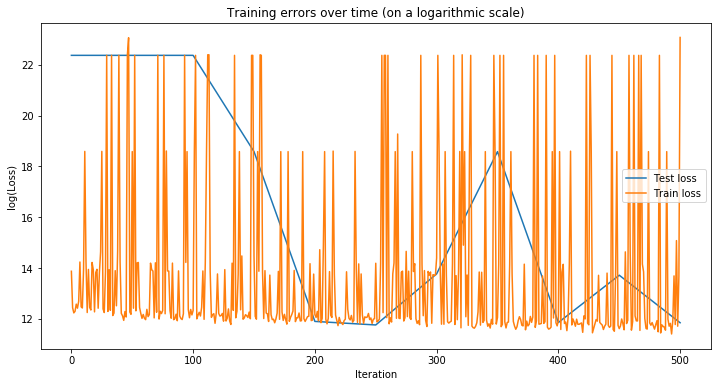

visualize 5 predictions data:
(14, 5, 1) (14, 5, 1)
(7, 5, 1)


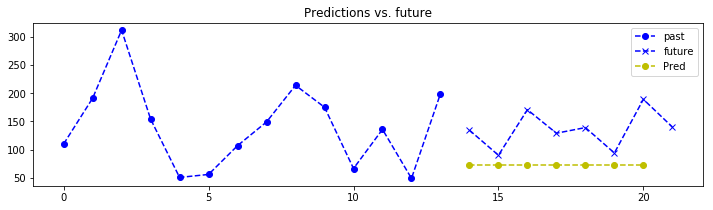

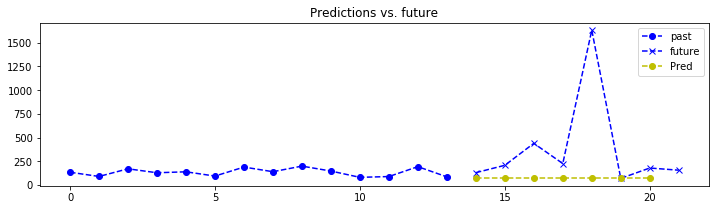

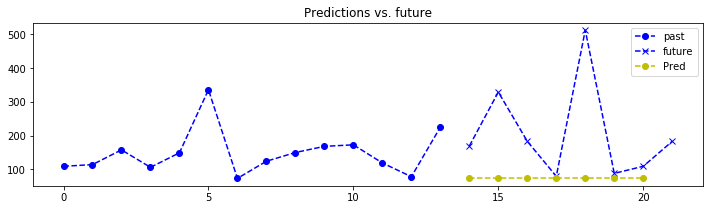

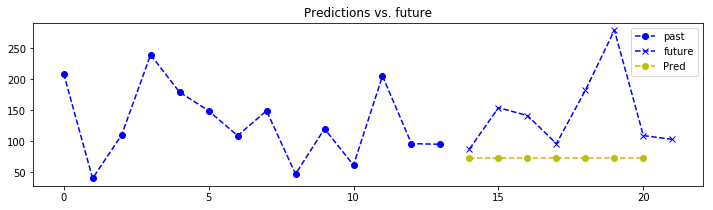

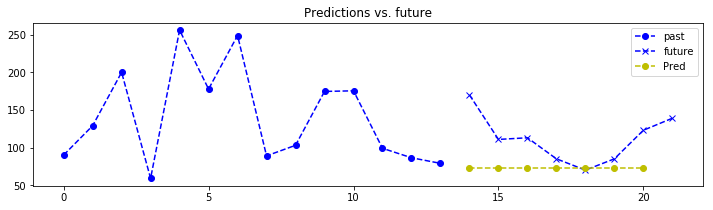

In [4]:
# Plot loss over time:
plt.figure(figsize=(12, 6))
plt.plot(np.array(range(0, len(test_losses))) /
    float(len(test_losses) - 1) * (len(train_losses) - 1),
    np.log(test_losses),label="Test loss")
    
plt.plot(np.log(train_losses),label="Train loss")
plt.title("Training errors over time (on a logarithmic scale)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend(loc='best')
plt.show()        
        
        
# Test
nb_predictions = 5
print("visualize {} predictions data:".format(nb_predictions))

preout =[]
X, Y = generate_data(isTrain=False, batch_size=nb_predictions)
print(np.shape(X),np.shape(Y))
for tt in  range(seq_length):
    feed_dict = {encoder_input[t]: X[t+tt] for t in range(seq_length)}
    feed_dict.update({expected_output[t]: Y[t+tt] for t in range(len(expected_output))})
    c =np.concatenate(( [np.zeros_like(Y[0])],Y[tt:seq_length+tt-1]),axis = 0)  #从前15个的最后一个开始预测  

    feed_dict.update({decode_input[t]: c[t] for t in range(len(c))})
    outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])
    preout.append(outputs[-1])

print(np.shape(preout))#将每个未知预测值收集起来准备显示出来。
preout =np.reshape(preout,[seq_length,nb_predictions,output_dim])

for j in range(nb_predictions):
    plt.figure(figsize=(12, 3))

    for k in range(output_dim):
        past = X[:, j, k]
        expected = Y[seq_length-1:, j, k]#对应预测值的打印

        pred = preout[:, j, k]

        label1 = "past" if k == 0 else "_nolegend_"
        label2 = "future" if k == 0 else "_nolegend_"
        label3 = "Pred" if k == 0 else "_nolegend_"
        plt.plot(range(len(past)), past, "o--b", label=label1)
        plt.plot(range(len(past), len(expected) + len(past)),
                 expected, "x--b", label=label2)
        plt.plot(range(len(past), len(pred) + len(past)),
                 pred, "o--y", label=label3)

    plt.legend(loc='best')
    plt.title("Predictions vs. future")
    plt.show()